In [1]:
from alignscore import AlignScore

scorer = AlignScore(model='roberta-large', batch_size=32, device='cuda:2', ckpt_path='../backup/AlignScore/AlignScore-large.ckpt', evaluation_mode='nli_sp')
score = scorer.score(contexts=['hello world.'], claims=['hello world.'])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/user/rosni/miniconda2/envs/scigen/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

In [2]:
import pandas as pd
import json

with open("../phi3-hyper-invalid2.json", "r") as f:
# Load dataset
#with open("phi3-base_test.json", "r") as f:
    data = json.load(f)


# Initialize lists to store extracted values
file_names = []
chain_labels = []
novelty_scores = []
alignment_scores_list1 = []
alignment_scores_list2 = []
chain_lengths = []
contexts = []
# Process data
for entry in data:
    metadata = entry["metadata"]
    file_name = metadata["file_name"]
    chain_label = metadata["chain_label"]  # 'valid' or 'invalid'
    
    # Extract novelty analysis
    novelty_analysis = entry["novelty_analysis"]

    novelty_score = novelty_analysis.get("novelty_result", {})  # Default to 'not novel'
    if novelty_score is None or not novelty_score.strip().startswith("{"):  # Avoid parsing if not valid JSON
        novelty_score = '{"Novelty score": null}'  # Assign a default JSON structure

    novelty_score = json.loads(novelty_score)
    
    # Extract alignment score
    generated_hypothesis = entry["generated_research_idea"]["Hypothesis"]
    target_hypothesis = " ".join(metadata["target_hypothesis"]["Target Hypotheses"])
    
    original_chain = entry.get("original_chain", [])
    concatenated_text = " ".join([f"({i+1}) {paper['title']} {paper['abstract']}" for i, paper in enumerate(original_chain)])
    if not generated_hypothesis or generated_hypothesis.strip() == "":
        continue
    
    # Lookup computed alignment score
    score1 = scorer.score(contexts=[target_hypothesis], claims=[generated_hypothesis])[0]  # Extract score
    score2 = scorer.score(contexts=[concatenated_text], claims=[generated_hypothesis])[0]  # Extract score

    chain_lengths.append(len(original_chain)-1)
    
    # Append to lists
    file_names.append(file_name)
    chain_labels.append(chain_label)
    novelty_scores.append(novelty_score["Novelty score"])
    alignment_scores_list1.append(score1)
    alignment_scores_list2.append(score2)
    contexts.append(concatenated_text)
    
# Create DataFrame
df_hyper = pd.DataFrame({
    "file_name": file_names,
    "chain_label": chain_labels,
    "context": contexts,
    "novelty_score": novelty_scores,
    "alignment_score_TH": alignment_scores_list1,
    "alignment_score_CT": alignment_scores_list2,
    "chain_length": chain_lengths
})




Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


In [3]:
import pandas as pd
import json

# Load dataset
with open("../phi3-hyper-invalid2.json", "r") as f:
#with open("phi3-base_test.json", "r") as f:
    data = json.load(f)

#output_file = "alignscore_hyper.csv"

# Initialize lists to store extracted values
file_names = []
chain_labels = []
explanation_groundedness_scores = []
chain_lengths = []
explanations = []
contexts = []
original_chains = []

# Process data
for entry in data:
    # Extract generated explanation (assume it's under 'generated_research_idea' -> 'Explanation')
    generated_analysis = json.dumps(entry["generated_research_idea"].get("Analysis", {}), indent=2)  # Convert to string
    generated_explanation = entry["generated_research_idea"].get("Rationale", "")
    generated_idea = entry["generated_research_idea"].get("Research idea", "")
    generated_hypothesis = entry["generated_research_idea"].get("Hypothesis", "")

    # Combine all components into a single explanation string
    generated_full_explanation = f"{generated_explanation}\n{generated_idea}\n{generated_hypothesis}"
    if not generated_full_explanation.strip():
        print(f"Skipping {file_name} due to missing explanation")
        continue
    
    metadata = entry["metadata"]
    file_name = metadata["file_name"]
    chain_label = metadata["chain_label"]  # 'valid' or 'invalid'
    
    # Extract original reasoning chain
    original_chain = entry.get("original_chain", [])
    context = " ".join([f"({i+1}) {paper['title']} {paper['abstract']}" for i, paper in enumerate(original_chain)])
    
    if chain_label == "valid":
        reasoning_context = context
        align_score1 = scorer.score(
            contexts=[reasoning_context],  # The full reasoning chain
            claims=[generated_full_explanation]
        )[0]   # Extract score
        align_score2 = 0
        
    
    elif chain_label == "invalid_type2":
        valid_nodes = []
        invalid_nodes = []
        found_invalid = False  # Flag to detect the first invalid node

        for paper in original_chain:
            if paper.get("relevance", 1) == 0 and not found_invalid:
                found_invalid = True  # Mark that we've found the first invalid node
        
            if not found_invalid:
                valid_nodes.append(f"({len(valid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
            else:
                invalid_nodes.append(f"({len(invalid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
               
        # Create reasoning contexts
        valid_context = " ".join(valid_nodes) if valid_nodes else None
        invalid_context = " ".join(invalid_nodes) if invalid_nodes else None
        
        align_score1 = scorer.score(
                contexts=[valid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
        align_score2 = scorer.score(
                contexts=[invalid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
    elif chain_label == "invalid_type1":
        valid_nodes = []
        invalid_nodes = []

        for paper in original_chain:
            if paper.get("relevance", 1) == 0:
                invalid_nodes.append(f"({len(invalid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
            else:
                valid_nodes.append(f"({len(valid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")

        # Create reasoning contexts
        valid_context = " ".join(valid_nodes) if valid_nodes else None
        invalid_context = " ".join(invalid_nodes) if invalid_nodes else None
        
        
        align_score1 = scorer.score(
                contexts=[valid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
        align_score2 = scorer.score(
                contexts=[invalid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
    
    # Compute Explanation Groundedness using alignment score
    explanation_groundedness_score = (align_score1, align_score2)

    print(explanation_groundedness_score)
    
    # Append to lists
    file_names.append(file_name)
    chain_labels.append(chain_label)
    explanation_groundedness_scores.append(explanation_groundedness_score)
    chain_lengths.append(len(original_chain) - 1)  # Chain length excluding source paper
    contexts.append(context)
    explanations.append(generated_full_explanation)
    original_chains.append(original_chain)
    
# Create DataFrame
df_align_hyper = pd.DataFrame({
    "file_name": file_names,
    "chain_label": chain_labels,
    "original_chains": original_chains,
    "context": contexts,
    "explanation": explanations,
    "explanation_groundedness": explanation_groundedness_scores,
    "chain_length": chain_lengths
})

#output_file = "alignscore_hyper.csv"
#df_align_hyper.to_csv(output_file, index=False)
#print(f"Results saved to {output_file}")

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


(0.0030703083612024784, 0.3869016468524933)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


(0.5957256555557251, 0.10423088073730469)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


(0.4688173532485962, 0.01564030349254608)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


(0.2720102369785309, 0.18137851357460022)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


(0.3215486705303192, 0.1644449084997177)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


(0.5202050805091858, 0.1930566430091858)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


(0.2845674157142639, 0.31714242696762085)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


(0.21214662492275238, 0.06716586649417877)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


(0.1393653005361557, 0.32146212458610535)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


(0.347361296415329, 0.0762583464384079)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


(0.43718820810317993, 0.25290048122406006)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


(0.5916618704795837, 0.38367727398872375)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


(0.27001953125, 0.24097952246665955)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


(0.3510335087776184, 0.0009541852632537484)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


(0.16071878373622894, 0.3526141941547394)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


(0.24637283384799957, 0.16992612183094025)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


(0.5330010652542114, 0.23819513618946075)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


(0.18566013872623444, 0.22577467560768127)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


(0.06430133432149887, 0.04741601645946503)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(0.043209392577409744, 0.055266041308641434)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


(0.08118970692157745, 0.02796826884150505)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


(0.266601026058197, 0.316658616065979)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


(0.35657501220703125, 0.08013901114463806)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


(0.4054064452648163, 0.28921857476234436)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


(0.22001776099205017, 0.004529008641839027)


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


(0.08860781043767929, 0.01247821468859911)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


(0.625615656375885, 0.04222998768091202)


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

(0.3266468942165375, 0.44574785232543945)


In [4]:
import numpy as np

df_valid = df_align_hyper[df_align_hyper["chain_label"] == "invalid_type2"]

# Extract the first and second elements separately
first_items = [x[0] for x in df_valid["explanation_groundedness"]]
second_items = [x[1] for x in df_valid["explanation_groundedness"]]

mean_first = round(np.mean(first_items), 3)
std_first = round(np.std(first_items), 2)

mean_second = round(np.mean(second_items), 3)
std_second = round(np.std(second_items), 2)

# Display results
print(f"First Item - Mean: {mean_first}, Std: {std_first}")
print(f"Second Item - Mean: {mean_second}, Std: {std_second}")


First Item - Mean: 0.301, Std: 0.17
Second Item - Mean: 0.179, Std: 0.13


In [ ]:
df_align_hyper

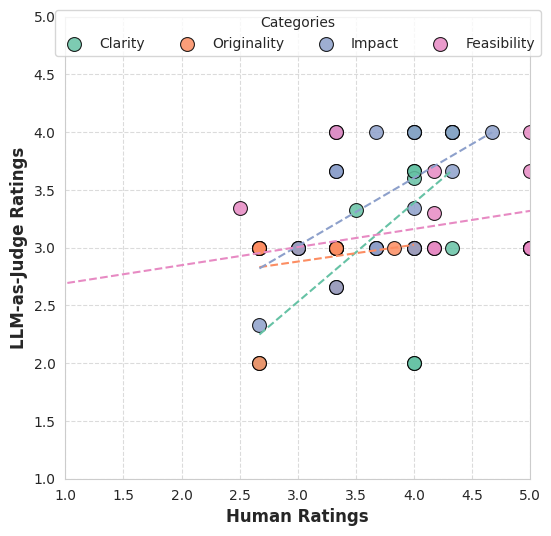

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define data
raw_data = """human_clarity\thuman_originality\thuman_impact\thuman_feasibility\tllm_clarity\tllm_relevance\tllm_originality\tllm_impact\tllm_feasibility
4.33	2.67	3.33	5	4	4	3	4	3
3.33	3	4	2.5	3	3	3	3.34	3.34
4	4	4.67	5	3.66	4	3	4	3.66
2.67	3.33	3.33	0.83	2	2	2.66	2.66	2
4	2.67	3.67	5	4	4	3	4	4
3.33	3.67	3.67	4.17	3	3	3	3	3
4	3.83	4	4.17	3.6	3.6	3	3	3.3
4.33	3.33	4.33	5	4	4	3	3.66	3
4.33	3	3.33	5	3	3	3	3.66	3
4	2.67	4.33	3.33	4	4	3	4	4
4	2.67	3	5	2	3	3	3	3
4	2.67	2.67	5	2	2.66	2	2.33	3
4.33	4	4	5	4	4	3	4	3
3.5	3.33	3.33	4.17	3.33	3	3	3.66	3
4	3.33	3.67	4.17	3.66	3.33	3	3	3.66"""

# Read data into a pandas DataFrame
data = pd.read_csv(pd.io.common.StringIO(raw_data), sep="\t")

# Define categories and colors
categories = {"clarity": "blue", "originality": "red", "impact": "magenta", "feasibility": "cyan"}

# Set Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))  # Square figure

# Define color palette
palette = sns.color_palette("Set2", len(categories))

# Create scatter plot
sns.scatterplot(x=data["human_clarity"], y=data["llm_clarity"], label="Clarity", color=palette[0], s=100, edgecolor="black", alpha=0.85)
sns.scatterplot(x=data["human_originality"], y=data["llm_originality"], label="Originality", color=palette[1], s=100, edgecolor="black", alpha=0.85)
sns.scatterplot(x=data["human_impact"], y=data["llm_impact"], label="Impact", color=palette[2], s=100, edgecolor="black", alpha=0.85)
sns.scatterplot(x=data["human_feasibility"], y=data["llm_feasibility"], label="Feasibility", color=palette[3], s=100, edgecolor="black", alpha=0.85)

# Add regression lines
sns.regplot(x=data["human_clarity"], y=data["llm_clarity"], scatter=False, color=palette[0], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})
sns.regplot(x=data["human_originality"], y=data["llm_originality"], scatter=False, color=palette[1], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})
sns.regplot(x=data["human_impact"], y=data["llm_impact"], scatter=False, color=palette[2], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})
sns.regplot(x=data["human_feasibility"], y=data["llm_feasibility"], scatter=False, color=palette[3], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})

# Labels and title
plt.xlabel("Human Ratings", fontsize=12, fontweight='bold')
plt.ylabel("LLM-as-Judge Ratings", fontsize=12, fontweight='bold')

# Single legend at bottom
plt.legend(title="Categories", loc="lower center", fontsize=10, bbox_to_anchor=(0.5, 0.9), ncol=4)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(1, 5)
plt.ylim(1, 5)

# Save plot as PDF
plt.savefig("human_vs_llm.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()


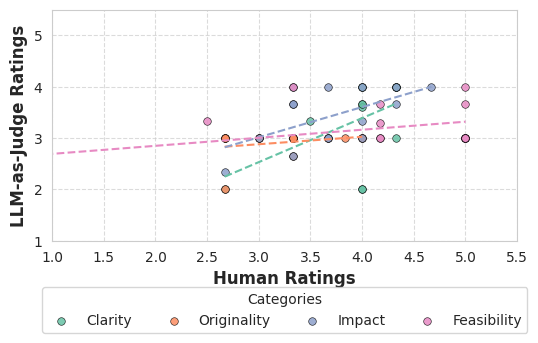

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO  # Correct import

# Define data
raw_data = """human_clarity\thuman_originality\thuman_impact\thuman_feasibility\tllm_clarity\tllm_relevance\tllm_originality\tllm_impact\tllm_feasibility
4.33	2.67	3.33	5	4	4	3	4	3
3.33	3	4	2.5	3	3	3	3.34	3.34
4	4	4.67	5	3.66	4	3	4	3.66
2.67	3.33	3.33	0.83	2	2	2.66	2.66	2
4	2.67	3.67	5	4	4	3	4	4
3.33	3.67	3.67	4.17	3	3	3	3	3
4	3.83	4	4.17	3.6	3.6	3	3	3.3
4.33	3.33	4.33	5	4	4	3	3.66	3
4.33	3	3.33	5	3	3	3	3.66	3
4	2.67	4.33	3.33	4	4	3	4	4
4	2.67	3	5	2	3	3	3	3
4	2.67	2.67	5	2	2.66	2	2.33	3
4.33	4	4	5	4	4	3	4	3
3.5	3.33	3.33	4.17	3.33	3	3	3.66	3
4	3.33	3.67	4.17	3.66	3.33	3	3	3.66"""

# Read data into a pandas DataFrame
data = pd.read_csv(StringIO(raw_data), sep="\t")  # Corrected

# Define categories and colors
categories = ["Clarity", "Originality", "Impact", "Feasibility"]
palette = sns.color_palette("Set2", len(categories))

# Set Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(6, 3))  # Square figure

# Create scatter plots
sns.scatterplot(x=data["human_clarity"], y=data["llm_clarity"], label="Clarity", color=palette[0], s=30, edgecolor="black", marker="o", alpha=0.85)
sns.scatterplot(x=data["human_originality"], y=data["llm_originality"], label="Originality", color=palette[1], s=30, edgecolor="black", marker="o", alpha=0.85)
sns.scatterplot(x=data["human_impact"], y=data["llm_impact"], label="Impact", color=palette[2], s=30, edgecolor="black", marker="o", alpha=0.85)
sns.scatterplot(x=data["human_feasibility"], y=data["llm_feasibility"], label="Feasibility", color=palette[3], s=30, edgecolor="black", marker="o", alpha=0.85)

# Add regression lines
sns.regplot(x=data["human_clarity"], y=data["llm_clarity"], scatter=False, color=palette[0], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})
sns.regplot(x=data["human_originality"], y=data["llm_originality"], scatter=False, color=palette[1], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})
sns.regplot(x=data["human_impact"], y=data["llm_impact"], scatter=False, color=palette[2], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})
sns.regplot(x=data["human_feasibility"], y=data["llm_feasibility"], scatter=False, color=palette[3], ci=None, line_kws={"linewidth": 1.5, "linestyle": "--"})

# Labels and title
plt.xlabel("Human Ratings", fontsize=12, fontweight='bold')
plt.ylabel("LLM-as-Judge Ratings", fontsize=12, fontweight='bold')

# Single legend at bottom
plt.legend(title="Categories", loc="upper center", fontsize=10, bbox_to_anchor=(0.5, -0.17), ncol=4)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(1, 5.5)
plt.ylim(1, 5.5)

# Save plot as PDF
plt.savefig("human_vs_llm.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()
